In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Embedding Generation

In this notebook we will do the following:

- Use the CSV file  from the previous Notebook
- Use the Dataset along with Vertex PaLM API to generate Embeddings
- Save the Embeddings to a Storage Bucket
- Create BigTable Table
- Save the Data to the Table

The diagram below shows the flow. We will perform all the steps except loading the embeddings to ME. As Matching Engine will take time to build out and needs its own focus.

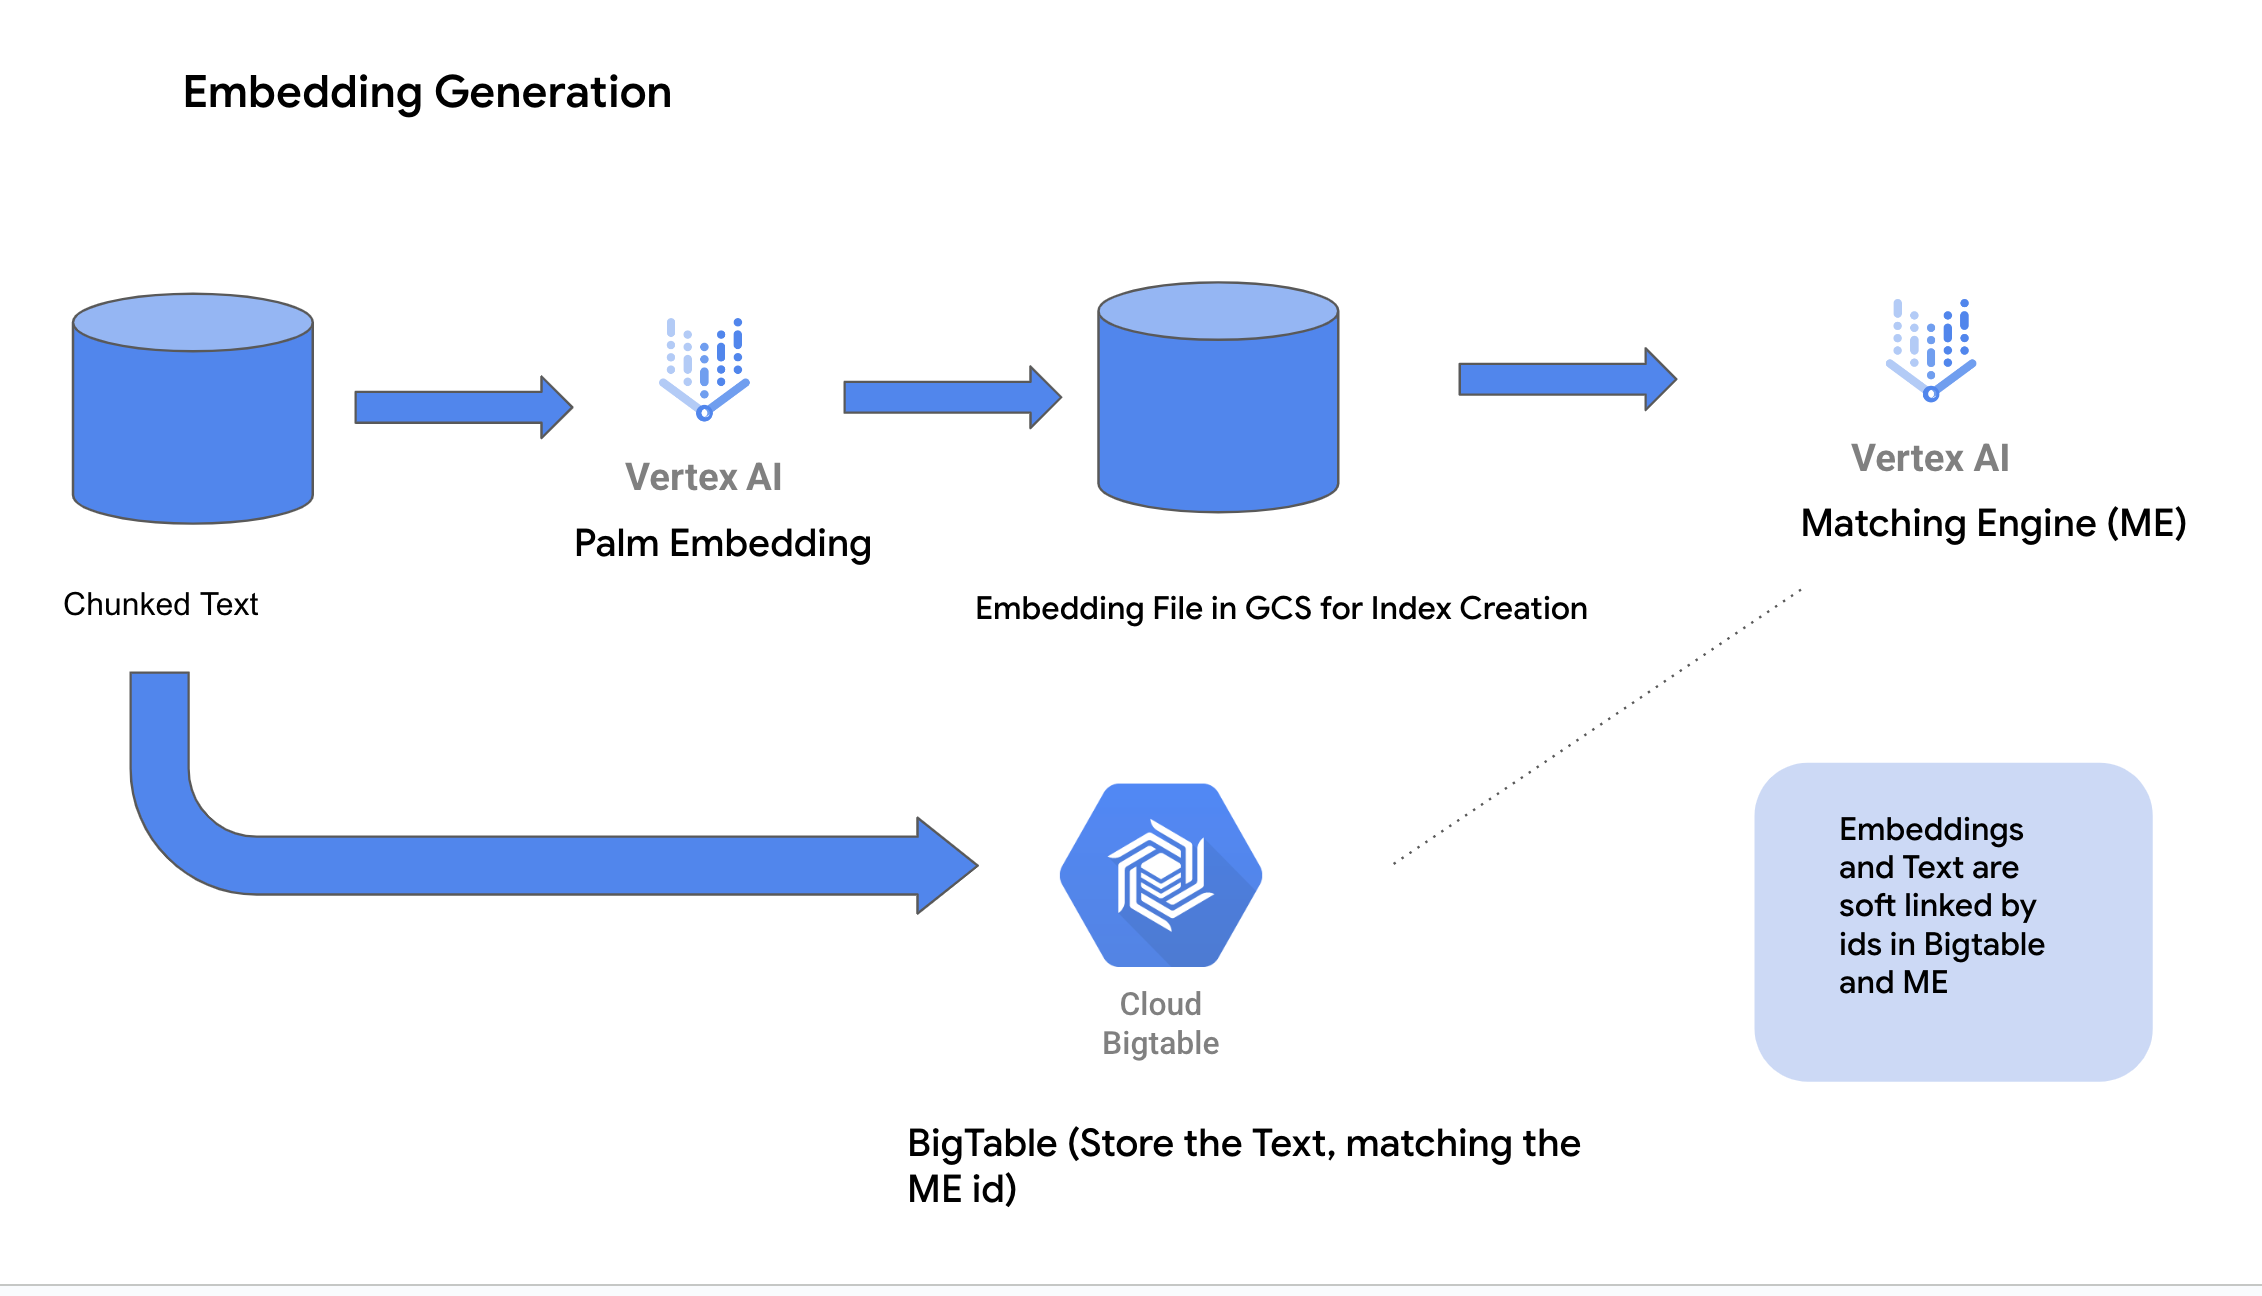

# Insall the needed libraries and Authenticate

In [ ]:
#Authenticate with your google cloud account
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
# Install the needed libraries
# Restart Runtime after this
! pip install -q google-cloud-aiplatform --upgrade


! pip install  -q google-cloud-bigtable

! pip install -q google-cloud-happybase==0.33.0



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.9 MB/s eta 0:00:00


---
!!! RESTART RUNTIME !!!
---
---

# Set Variables

In [ ]:
#from perviouse article gs://fifa_wikipedia_strings_demogct2022/wikipedia_strings.csv
from typing_extensions import ClassVar
PROJECT_ID = "demogct2022" #@param
Region = "us-central1" #@param
#BUCKET where Wikipedia CSV file is stored
BUCKET_TO_SAVE= f"fifa_wikipedia_strings_{PROJECT_ID}"#@param
BUCKET_EMBEDDINGS = f"fifa_wikipedia_embeddings_{PROJECT_ID}"#@param
CSV_FILE = "wikipedia_strings.csv" #@param
EMB_CSV_FILE = "wikipedia_w_embeddings.csv"#@param
EMB_STR_CSV_FILE = "wikipedia_w_str_embeddings.csv"#@param








#Import and initialize Vertex

In [ ]:
#import the needed packages
import pandas as pd
import numpy as np
import os
import json
import vertexai
from vertexai.preview.language_models import TextEmbeddingModel, TextGenerationModel
from google.cloud import storage


In [ ]:
# Initialize Vertex AI
vertexai.init(project=PROJECT_ID,location=Region)


#Utility Functions to work with GCS

In [ ]:
# Download the file locally

def download_blob(bucket_name, source_blob_name, destination_file_name):
  """Downloads a blob from the bucket."""
  storage_client = storage.Client(project=PROJECT_ID)
  bucket = storage_client.get_bucket(BUCKET_TO_SAVE)
  blob = bucket.blob(CSV_FILE)
  blob.download_to_filename(CSV_FILE)

  if  os.path.exists(CSV_FILE):
    print(f"File {CSV_FILE} downloaded successfully")
  else:
    print(f"File {CSV_FILE} does not exist")



def upload_blob(bucket_name, source_file_name, destination_blob_name, REGION = "us-central1", PROJECT_ID="demogct2022"):
  """Uploads a file to the bucket. If the bucket does not exists it creates the bucket"""
  # Create a storage client
  client = storage.Client(project=PROJECT_ID)
  bucket = client.bucket(bucket_name)
  bucket.location = REGION

  try:
    bucket = client.get_bucket(bucket_name)
    print(f"Bucket {bucket_name} exists.")
  except:
    print(f"Creating bucket {bucket_name}")
    bucket.create()
    print(f"Bucket {bucket_name} created.")


  # Check if the wikipedia_strings.csv file exists locally
  if os.path.exists(source_file_name):
    # Copy the file
    #client.copy_file('wikipedia_strings.csv', f'gs://{BUCKET_TO_SAVE}/wikipedia_strings.csv')
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print(f"Blob {destination_blob_name} uploaded to {bucket_name}.")
  else:
    print(f"The {source_file_name} file does not exist.")
    print ("Please save the dataframe in the above frames")

  stats = storage.Blob(bucket=bucket, name = destination_blob_name).exists(client)
  if stats:
    print(f"Blob gs://{bucket_name}/wikipedia_strings.csv exists.")
  else:
    print(f"Blob gs://{bucket_name}/wikipedia_strings.csv does not exist.")



#Download the file and load to Pandas

In [ ]:
#@TODO Download file
download_blob(BUCKET_TO_SAVE, CSV_FILE,BUCKET_TO_SAVE)

File wikipedia_strings.csv downloaded successfully


In [ ]:
!ls

fifa_wikipedia_strings.csv  sample_data  wikipedia_strings.csv


In [ ]:
#Pandas read data from gcs bucker
df = pd.read_csv(CSV_FILE)
df.head()

,Unnamed: 0,text
0,0,Matthias Ginter\n\n{{Short description|German ...
1,1,Matthias Ginter\n\n==Club career==\n\n\n
2,2,Matthias Ginter\n\n==Club career==\n\n===Early...
3,3,Matthias Ginter\n\n==Club career==\n\n===Borus...
4,4,Matthias Ginter\n\n==Club career==\n\n===Borus...


#Generate Embeddings using PaLM API

In [ ]:
# Load the Text Embedding Model

model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

In [ ]:
#Given a list of strings, generate embeddings
#Since the API only supports a max of 5 strings, we will batch it up
def gen_embeddings( wikipedia_strings):
 index = 0
 allembeddings = []
 for i in range(5,len (wikipedia_strings)+1,5):
   print(i)
   embedarr = model.get_embeddings(wikipedia_strings[index:i] )
   allembeddings.append(embedarr)
   index = i
 return allembeddings

#Flatten the list
def flatten(allembeddings):
 flatlist = []
 for l in allembeddings:
    for e in l:
        flatlist.append(e.values)
 return flatlist

# Generate wikipedia list from dataframe
def generate_wiki_list (df):
  wikipedia_list = []
  for i in range(len(df)):
    wikipedia_list.append(df.iloc[i]['text'])
  return wikipedia_list

# Tie all the above methods to generate Embeddings from the df
def generate_embeddings(df):
  wikipedia_list = generate_wiki_list(df)
  allembeddings = gen_embeddings(wikipedia_list)
  flattened_list = flatten(allembeddings)
  return flattened_list


In [ ]:
# Generate Embeddings
# This will take some time to run
allEmbeddings = generate_embeddings(df)



5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
1220

#Load the Embeddings and Text in a DataFrame

In [ ]:
#Generate a DF Embeddings
medf = pd.DataFrame()
medf['embeddings'] = allEmbeddings
medf['wikipedia_string'] = df['text']
medf.head()



,embeddings,wikipedia_string
0,"[0.00844938401132822, -0.012390978634357452, 0...",Matthias Ginter\n\n{{Short description|German ...
1,"[-0.019625317305326462, 0.028688296675682068, ...",Matthias Ginter\n\n==Club career==\n\n\n
2,"[-0.007332859095185995, -0.017253633588552475,...",Matthias Ginter\n\n==Club career==\n\n===Early...
3,"[0.0003593577421270311, -0.0024278108030557632...",Matthias Ginter\n\n==Club career==\n\n===Borus...
4,"[-0.005242270417511463, -0.002086398657411337,...",Matthias Ginter\n\n==Club career==\n\n===Borus...


# Save the Embeddings in CSV

In [ ]:
medf.to_csv(EMB_STR_CSV_FILE)


In [ ]:
#@Todo: Upload the above file to GCS

#Prepare a File for Matchinge Engine

In this section we will prepare a CSV file of format
id, Embeddings

This will be be stored in GCS and used by the Matching Engine to Create Index

In [ ]:
# Generate a CSV file with id and Embeddings
def gen_emb_csv(medf, csvfname):
 with open(csvfname, "w") as f:
    for i in range(medf.embeddings.size):
        f.write( str(i) + ',')
        f.write( ",".join(str(medf.embeddings[i])[1:-1].split(",")))
        f.write("\n")

In [ ]:
#Filename for CSV to be saved
#fname = "wikipedia_string_w_embeddings.csv"#@param
#fname = "wikipedia_w_embeddings.csv"#@param
print(EMB_STR_CSV_FILE)
print(EMB_CSV_FILE)

wikipedia_w_str_embeddings.csv
wikipedia_w_embeddings.csv


In [ ]:
#Generate the embedding file
gen_emb_csv(medf,EMB_CSV_FILE)

In [ ]:
BUCKET_EMBEDDINGS


'fifa_wikipedia_embeddings_demogct2022'

In [ ]:
#Check the file has been generated and then uplaod to the bucket
if  os.path.exists(EMB_CSV_FILE):
  print(f"File {EMB_CSV_FILE} exists.")
  upload_blob(BUCKET_EMBEDDINGS,EMB_CSV_FILE, EMB_CSV_FILE)

File wikipedia_w_embeddings.csv exists.


<ipython-input-47-334512020eea>:22: DeprecationWarning: Assignment to 'Bucket.location' is deprecated, as it is only valid before the bucket is created. Instead, pass the location to `Bucket.create`.
  bucket.location = REGION


Creating bucket fifa_wikipedia_embeddings_demogct2022
Bucket fifa_wikipedia_embeddings_demogct2022 created.
Blob wikipedia_w_embeddings.csv uploaded to fifa_wikipedia_embeddings_demogct2022.
Blob gs://fifa_wikipedia_embeddings_demogct2022/wikipedia_strings.csv exists.


In [ ]:
BUCKET_URI = f"gs://{BUCKET_EMBEDDINGS}"

In [ ]:
!gsutil ls $BUCKET_URI

gs://fifa_wikipedia_embeddings_demogct2022/wikipedia_w_embeddings.csv


# Save the Text Data to BigTable

In this section we will uplaod he text into BigTable so that it can be used later on.
*******************************************************************************
Assumption
*******************************************************************************
The Next Section Assumes that you have already created a BigTable Instance and Table using the Console.
 * [BigTable](https://cloud.google.com/bigtable/docs/creating-instance)

 Ensure that you note the Table Name, Instance Id from the console outside this demo. Due to colab permissions limitations and complexity we have kept the process outside.

 Assuming you have the above values, please proceed to the next section.


In [ ]:
from google.cloud import bigtable
from google.cloud import happybase
import pandas as pd

PROJECT_ID = "demogct2022" #@param
INSTANCE_ID = "bus-instance" #@param
TABLE_ID = "masterdata" #@param
COLUMN_FAMILY_NAME = "cf1" #@param
#Change this to match the category you are working with
#Else the keys will be overwritten
rkey_prefix = "fifa_wikipedia_string"#@param

In [ ]:
#Connect to the BigTable
#Define the column family
#Define the column name format
client = bigtable.Client(project=PROJECT_ID, admin=True)
instance = client.instance(INSTANCE_ID)
connection = happybase.Connection(instance=instance)
table = connection.table(TABLE_ID)
column_family_name = COLUMN_FAMILY_NAME
column_name = "{fam}:content".format(fam=column_family_name)

In [ ]:
if df is not None:
  print(df.head())

   Unnamed: 0                                               text
0           0  Matthias Ginter\n\n{{Short description|German ...
1           1           Matthias Ginter\n\n==Club career==\n\n\n
2           2  Matthias Ginter\n\n==Club career==\n\n===Early...
3           3  Matthias Ginter\n\n==Club career==\n\n===Borus...
4           4  Matthias Ginter\n\n==Club career==\n\n===Borus...


In [ ]:
from genericpath import exists
#Loading the file again incase we have lost handle to the earler dataframe
if df is not None:
  df = pd.read_csv(CSV_FILE)


# Lets us define a row key. Over here we will create keys in the format
# wikipedia_string#0001
# Since BigTable keys are in lexical order, we need to make sure that it is ordered correctly
def get_row_key(index, max_size):
   rkey = rkey_prefix + "#" + str(index).zfill(max_size)
   return rkey

# Function to put data to a table
def putTable(table, column_name, wiki_text, df_index, df_num_digits):
  row_key = get_row_key(df_index, df_num_digits)

  table.put(row_key, {column_name.encode("utf-8"): wiki_text.encode("utf-8")})
  #print ("Data Entered")
  return row_key



---
The code below should run once without interruption. If you do interrupt and run again, you will end with duplicates. If you do need to run again, change rkey_prefix.
---
---

In [ ]:

'''
Load all the data into the table
This should be run once only
'''
import traceback
max_size = len(str(df.size))
index=0
for row in df.text:
  try:
   putTable(table, column_name, row, index, max_size)
  except Exception as e:
   print("error" , e)
   traceback.print_exc()

  index = index + 1

Streaming output truncated to the last 5000 lines.
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered
Data Entered


In [ ]:
print ("Note this value as we will use it in the final notebooks to form the key for BigTable")
print(max_size)


Note this value as we will use it other notebooks to form the key
5


In [ ]:
#@Todo: Write some tests out

This concludes the section were we have finished
* Generating Embeddings
* Saving the file to BigTable

In the next [notebook](https://colab.sandbox.google.com/drive/1decZy9J_fnw-QhIfOADPjgMyIYXmjtuR?resourcekey=0-QeDPrf9fzdNj0IYOQuP4dg#scrollTo=3TXdZLXkSTlI) we will Use Vertex Matching Engine to create and index with Embedding file created and deploy it to a Public Endpoint.

